In [ ]:
import subprocess

try:
  import google.colab
  subprocess.run(['python', '-m', 'pip', 'install', 'skorch', 'torch'])
except ImportError:
  pass

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from skorch import NeuralNetClassifier
from sklearn.metrics import accuracy_score

In [ ]:
mnist = fetch_openml('mnist_784', data_home='datasets', as_frame=False, cache=False)
mnist.data.shape
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X.min(), X.max()

(0.0, 1.0)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])
X_train.shape, y_train.shape

((52500, 784), (52500,))

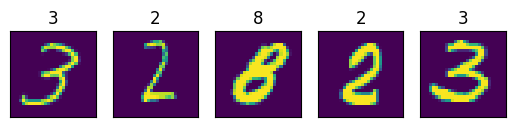

In [ ]:
def plot_example(X,y):
  for i, (img,y) in enumerate(zip(X[:5].reshape(5,28,28),y[:5])):
    plt.subplot(151+i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(y)

plot_example(X_train,y_train)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))
mnist_dim, hidden_dim, output_dim

(784, 98, 10)

In [ ]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
      X = F.relu(self.hidden(X))
      X = self.dropout(X)
      X = F.softmax(self.output(X), dim=-1)
      return X

In [ ]:
torch.manual_seed(0);
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=100,
    lr=0.1,
    device=device,
)

In [ ]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8387       0.8800        0.4174  1.5650
      2        0.4332       0.9103        0.3133  0.9102
      3        0.3612       0.9233        0.2684  0.9086
      4        0.3233       0.9309        0.2317  0.9009
      5        0.2938       0.9353        0.2173  1.0497
      6        0.2738       0.9390        0.2039  1.1993
      7        0.2600       0.9454        0.1868  1.2119
      8        0.2427       0.9484        0.1757  0.9019
      9        0.2362       0.9503        0.1683  1.2428
     10        0.2226       0.9512        0.1621  0.8939
     11        0.2184       0.9529        0.1565  0.8895
     12        0.2090       0.9541        0.1508  0.8982
     13        0.2067       0.9570        0.1446  0.8871
     14        0.1978       0.9570        0.1412  0.8778
     15        0.1923       0.9582        0.1392  0.8920
     16        0.1889       0.9

In [ ]:
y_pred = net.predict(X_test)
accuracy_score(y_test, y_pred)

0.9732571428571428

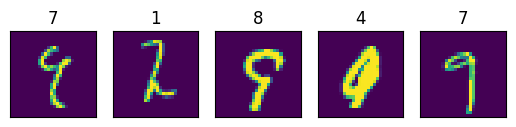

In [ ]:
error_mask = y_pred != y_test
plot_example(X_test[error_mask],y_pred[error_mask])

In [ ]:
XCnn = X.reshape(-1,1,28,28)
XCnn.shape

(70000, 1, 28, 28)

In [ ]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [ ]:
class Cnn(nn.Module):
  def __init__(self,dropout=0.5):
    super(Cnn,self).__init__()
    self.conv1 = nn.Conv2d(1,32,kernel_size=3)
    self.conv2 = nn.Conv2d(32,64,kernel_size=3)
    self.conv2_drop = nn.Dropout2d(p=dropout)
    self.fc1 = nn.Linear(1600,100)
    self.fc2 = nn.Linear(100,10)
    self.fc1_drop = nn.Dropout(p=dropout)

  def forward(self,x):
    x = F.relu(F.max_pool2d(self.conv1(x),2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = torch.relu(self.fc1_drop(self.fc1(x)))
    x = torch.softmax(self.fc2(x),dim=-1)
    return x

In [ ]:
torch.manual_seed(0);

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=20,
    lr=0.001,
    optimizer=torch.optim.Adam,
    device=device,
)

In [ ]:
cnn.fit(XCnn_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5080       0.9691        0.1028  2.4470
      2        0.1675       0.9773        0.0752  1.4273
      3        0.1359       0.9821        0.0614  1.4243
      4        0.1112       0.9854        0.0520  1.5082
      5        0.0978       0.9864        0.0477  1.7990
      6        0.0929       0.9866        0.0440  1.4842
      7        0.0832       0.9870        0.0423  1.4126
      8        0.0809       0.9888        0.0386  1.4144
      9        0.0736       0.9890        0.0382  1.4188
     10        0.0693       0.9893        0.0380  1.4318
     11        0.0668       0.9888        0.0367  1.4104
     12        0.0607       0.9890        0.0369  1.4408
     13        0.0591       0.9890        0.0360  1.7507
     14        0.0573       0.9902        0.0335  1.6751
     15        0.0568       0.9893        0.0349  1.4123
     16        0.0536       0.9

In [ ]:
y_pred_cnn = cnn.predict(XCnn_test)
cnn.predict_proba(XCnn_test)

array([[1.0260908e-16, 5.1670776e-15, 2.3615224e-11, ..., 2.8916401e-13,
        1.0000000e+00, 7.4994678e-14],
       [3.3424751e-21, 1.1979609e-10, 1.4155093e-13, ..., 3.0629418e-10,
        5.6380004e-13, 3.7195302e-10],
       [1.2081772e-08, 4.1316190e-07, 8.2653857e-09, ..., 1.5594917e-08,
        9.8634911e-01, 5.0990011e-06],
       ...,
       [3.7597921e-15, 2.8728075e-16, 6.1419627e-21, ..., 6.5817656e-17,
        3.5359889e-11, 3.1761654e-10],
       [1.6589655e-10, 5.6374152e-08, 4.2640821e-10, ..., 2.1054414e-06,
        9.9815387e-01, 6.3765678e-04],
       [1.8992833e-07, 1.8661224e-06, 9.9996340e-01, ..., 1.4847515e-05,
        6.7025024e-07, 5.3234139e-08]], dtype=float32)

In [ ]:
accuracy_score(y_test, y_pred_cnn)

0.9904

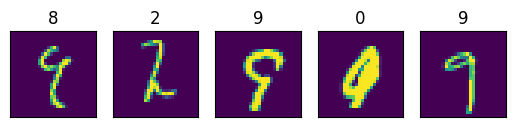

In [ ]:
plot_example(X_test[error_mask],y_pred_cnn[error_mask])

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/MyDrive/AppliedAiLabs"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['number2.jpg',
 'number1.jpg',
 'number3.jpg',
 'number4.jpg',
 'number5.jpg',
 'number6.jpg',
 'number7.jpg',
 'number8.jpg',
 'number9.jpg',
 'thick1.jpg',
 'thick2.jpg',
 'thick3.jpg',
 'thick4.jpg',
 'thick5.jpg',
 'thick6.jpg',
 'thick7.jpg',
 'thick9.jpg',
 'thick8.jpg']

(148, 232)
Press ENTER to exit
(166, 245)
(137, 222)
(148, 228)
(182, 264)


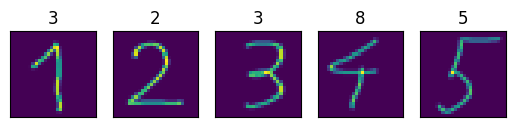

In [ ]:
from PIL import Image,ImageOps
import numpy as np
import os
import cv2

img = Image.open("number1.jpg")#.convert("1")
print(img.size)
input("Press ENTER to exit")
imge = img.resize((28,28),Image.BILINEAR).convert("L")
imgeinverted = ImageOps.invert(imge)
im2arr = np.array(imgeinverted)
im2arr = im2arr.reshape(1,784)
X_test[0] = im2arr

img2 = Image.open("number2.jpg")
print(img2.size)
imge2 = img2.resize((28,28),Image.BILINEAR).convert("L")
imgeinverted2 = ImageOps.invert(imge2)
im2arr2 = np.array(imgeinverted2)
im2arr2 = im2arr2.reshape(1,784)
X_test[1] = im2arr2


img3 = Image.open("number3.jpg")
print(img3.size)
imge3 = img3.resize((28,28),Image.BILINEAR).convert("L")
imgeinverted3 = ImageOps.invert(imge3)
im2arr3 = np.array(imgeinverted3)
im2arr3 = im2arr3.reshape(1,784)
X_test[2] = im2arr3

img4 = Image.open("number4.jpg")
print(img4.size)
imge4 = img4.resize((28,28),Image.BILINEAR).convert("L")
imgeinverted4 = ImageOps.invert(imge4)
im2arr4 = np.array(imgeinverted4)
im2arr4 = im2arr4.reshape(1,784)
X_test[3] = im2arr4

img5 = Image.open("number5.jpg")
print(img5.size)
imge5 = img5.resize((28,28),Image.BILINEAR).convert("L")
imgeinverted5 = ImageOps.invert(imge5)
im2arr5 = np.array(imgeinverted5)
im2arr5 = im2arr5.reshape(1,784)
X_test[4] = im2arr5


y_pred = net.predict(X_test)
plot_example(X_test,y_pred)


(148, 232)
Press ENTER to exit
(166, 245)
(137, 222)
(148, 228)
(182, 264)


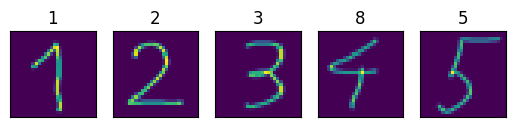

In [ ]:
from PIL import Image,ImageOps
import numpy as np
import os
import cv2

img = Image.open("number1.jpg")#.convert("1")
print(img.size)
input("Press ENTER to exit")
imge = img.resize((28,28),Image.BILINEAR).convert("L")
imgeinverted = ImageOps.invert(imge)
im2arr = np.array(imgeinverted)
im2arr = im2arr.reshape(1,28,28)
XCnn_test_modified=XCnn_test.copy()
XCnn_test_modified[0] = im2arr


img1 = Image.open("number2.jpg")#.convert("1")
print(img1.size)
imge1 = img1.resize((28,28),Image.BILINEAR).convert("L")
imgeinverted1 = ImageOps.invert(imge1)
im2arr2 = np.array(imgeinverted1)
im2arr2 = im2arr2.reshape(1,28,28)
XCnn_test_modified[1] = im2arr2

img2 = Image.open("number3.jpg")#.convert("1")
print(img2.size)
imge2 = img2.resize((28,28),Image.BILINEAR).convert("L")
imgeinverted2 = ImageOps.invert(imge2)
im2arr3 = np.array(imgeinverted2)
im2arr3 = im2arr3.reshape(1,28,28)
XCnn_test_modified[2] = im2arr3

img3 = Image.open("number4.jpg")#.convert("1")
print(img3.size)
imge3 = img3.resize((28,28),Image.BILINEAR).convert("L")
imgeinverted3 = ImageOps.invert(imge3)
im2arr4 = np.array(imgeinverted3)
im2arr4 = im2arr4.reshape(1,28,28)
XCnn_test_modified[3] = im2arr4

img4 = Image.open("number5.jpg")#.convert("1")
print(img4.size)
imge4 = img4.resize((28,28),Image.BILINEAR).convert("L")
imgeinverted4 = ImageOps.invert(imge4)
im2arr5 = np.array(imgeinverted4)
im2arr5 = im2arr5.reshape(1,28,28)
XCnn_test_modified[4] = im2arr5

y_pred_cnn = cnn.predict(XCnn_test_modified)
plot_example(XCnn_test_modified,y_pred_cnn)